In [1]:
#Set different parameter choices
sigma = [.005, .01, .02]
b = [.04, .06]
t = [1/12]
a = [1, .5, .25]

In [2]:
import itertools
import numpy as np
#By using itertools.product we can get all combinations possible
params = np.array(list(itertools.product(*(sigma, b, t, a))))
print(params)

[[0.005      0.04       0.08333333 1.        ]
 [0.005      0.04       0.08333333 0.5       ]
 [0.005      0.04       0.08333333 0.25      ]
 [0.005      0.06       0.08333333 1.        ]
 [0.005      0.06       0.08333333 0.5       ]
 [0.005      0.06       0.08333333 0.25      ]
 [0.01       0.04       0.08333333 1.        ]
 [0.01       0.04       0.08333333 0.5       ]
 [0.01       0.04       0.08333333 0.25      ]
 [0.01       0.06       0.08333333 1.        ]
 [0.01       0.06       0.08333333 0.5       ]
 [0.01       0.06       0.08333333 0.25      ]
 [0.02       0.04       0.08333333 1.        ]
 [0.02       0.04       0.08333333 0.5       ]
 [0.02       0.04       0.08333333 0.25      ]
 [0.02       0.06       0.08333333 1.        ]
 [0.02       0.06       0.08333333 0.5       ]
 [0.02       0.06       0.08333333 0.25      ]]


In [3]:
#Each column is given to one of the variables
sigma = list(params[:,0])
b = list(params[:,1])
t = list(params[:,2])
a = list(params[:,3])

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

#Set an initial interest rate
initial_state = {'r': .08}


#Basic vasicek rate change model
def rate_change(r, a=.5, b=.06, sigma=.02, t=1/12):
    delta = a* (b-r) * t + sigma * t ** .5 * norm.ppf(np.random.RandomState().rand())
    return delta + r


#Policy for updating
def vasicek_policy(_params, substep, sH, s):
    r = rate_change(s['r'], _params['a'], _params['b'], _params['sigma'], _params['t'])
    return {'r': r}

#Simple state update
def update_rate(_params, substep, sH, s, _input):
    return ('r', _input['r'])

#Partial updates
PSUBs = [
    {
        "policies": {
            "rate_policy": vasicek_policy,
        },
        "variables": {
            "r": update_rate,
        }
    }
]

#Set simulation parameters

#The M parameter will let us test different combinations of parameters
sim_config_dict = {
    'T': range(360),
    'N': 100,
"M": {'a': a, 'b':b, 'sigma':sigma, 't':t}}

c = config_sim(sim_config_dict)


exp = Experiment()
exp.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = PSUBs,
    sim_configs = c
)


exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.single_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_result, field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: single_proc
Configuration Count: 18
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (360, 4, 100, 1)
Execution Method: parallelize_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2

Total execution time: 203.02s


In [5]:
#Find the mean rates over time
mu = result.groupby(['timestep', 'simulation'])['r'].mean().unstack()
print(mu)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.080000  0.080000  0.080000  0.080000  0.080000  0.080000   
1           0.076683  0.078357  0.079410  0.078354  0.078960  0.079362   
2           0.073497  0.076468  0.078845  0.076825  0.078270  0.079005   
3           0.071027  0.074818  0.077974  0.075519  0.077377  0.078703   
4           0.068471  0.073268  0.077123  0.074448  0.076653  0.078058   
...              ...       ...       ...       ...       ...       ...   
356         0.040340  0.039483  0.039810  0.059909  0.060046  0.060280   
357         0.040227  0.039272  0.039869  0.059939  0.060134  0.060508   
358         0.040027  0.039426  0.039813  0.059801  0.060208  0.060829   
359         0.039979  0.039294  0.039936  0.059582  0.060175  0.060643   
360         0.040012  0.039300  0.039870  0.059739  0.060259  0.060664   

simulation        6         7        

In [6]:
#Turn the parameters into a dataframe
params = pd.DataFrame(params, columns = ['sigma', 'b', 't', 'a'])

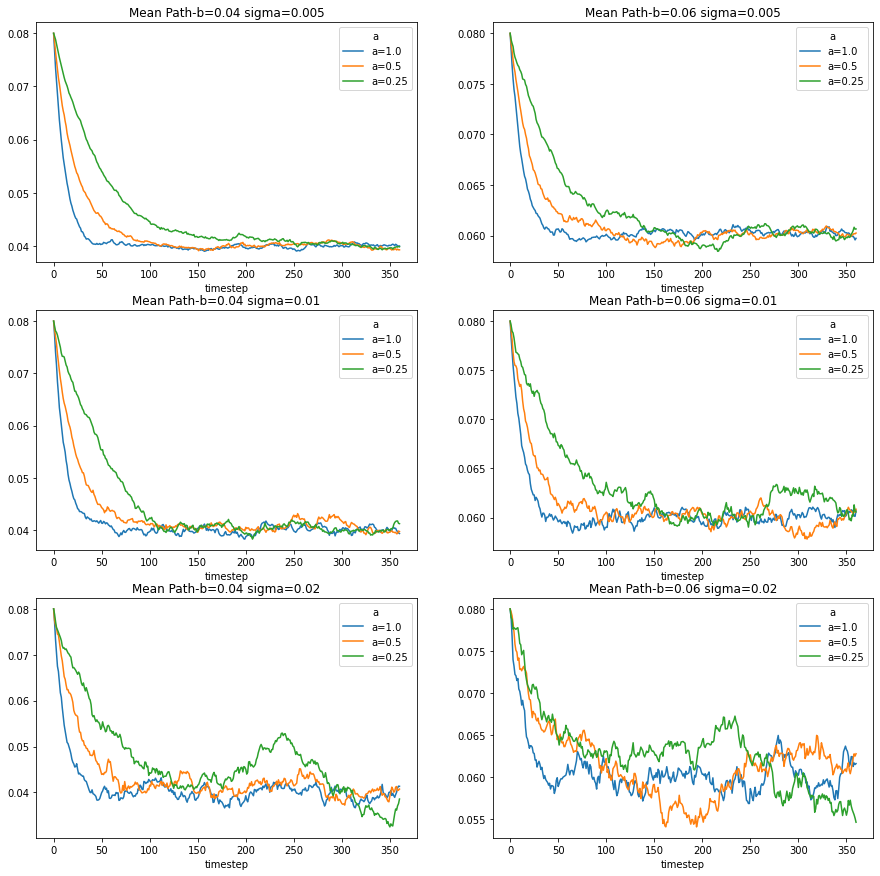

In [7]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Mean Path-b={} sigma={}".format(b,sigma))
        ts = mu[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

In [8]:
#Find the standard deviation of rates between each simulation
std_cross_section = result.groupby(['timestep', 'simulation'])['r'].std().unstack()
print(std_cross_section)

simulation        0         1         2         3         4         5   \
timestep                                                                 
0           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1           0.001494  0.001333  0.001441  0.001450  0.001460  0.001450   
2           0.001942  0.001858  0.002025  0.002118  0.001979  0.002140   
3           0.002315  0.002242  0.002446  0.002625  0.002438  0.002398   
4           0.002509  0.002795  0.002827  0.002693  0.002901  0.002594   
...              ...       ...       ...       ...       ...       ...   
356         0.003514  0.003710  0.007125  0.003827  0.004801  0.007339   
357         0.003502  0.003763  0.007137  0.003792  0.004731  0.007317   
358         0.003607  0.003880  0.006854  0.003843  0.004781  0.007446   
359         0.003519  0.003857  0.006970  0.003696  0.004618  0.007531   
360         0.003496  0.004163  0.006845  0.003288  0.004760  0.007269   

simulation        6         7        

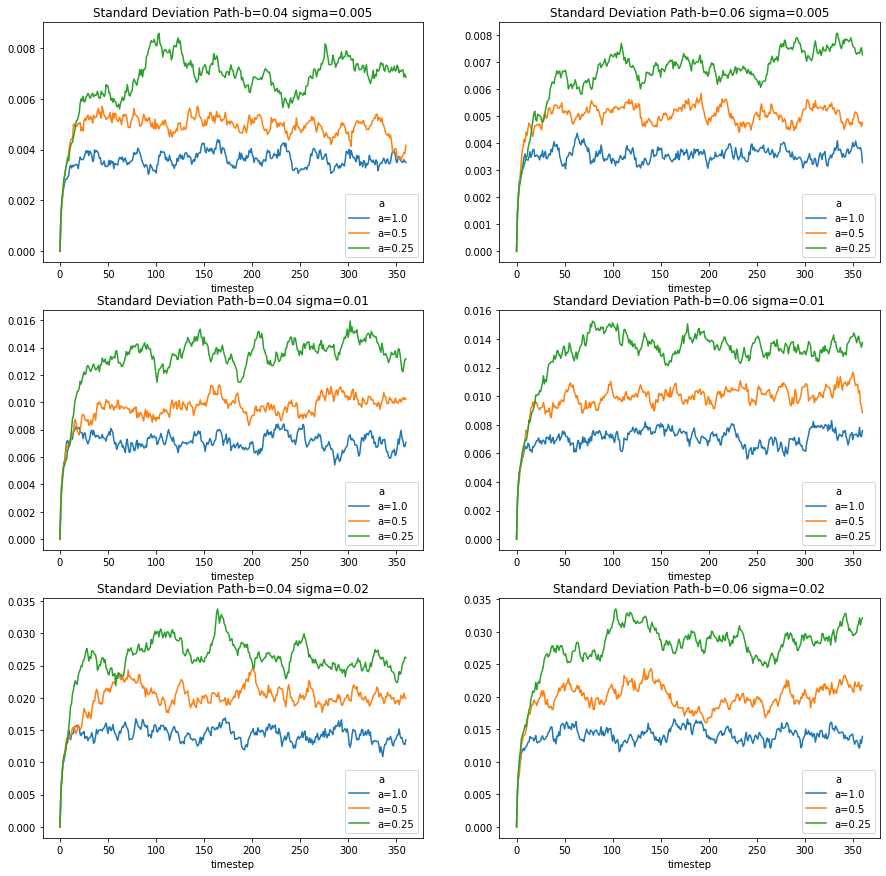

In [9]:
fig, ax = plt.subplots(nrows=len(params['sigma'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, sigma in enumerate(params['sigma'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Standard Deviation Path-b={} sigma={}".format(b,sigma))
        ts = std_cross_section[params[(params['sigma'] == sigma) & (params['b'] == b)].index]
        ts.columns = params[(params['sigma'] == sigma) & (params['b'] == b)]['a']
        ts.columns = "a="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()

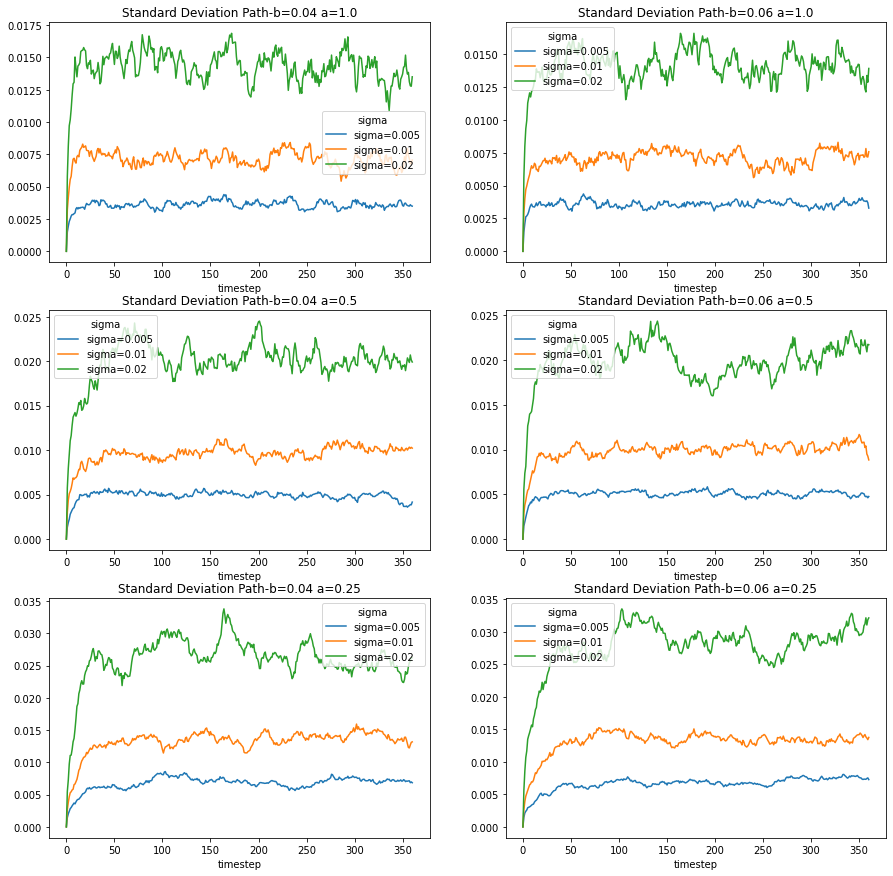

In [10]:
fig, ax = plt.subplots(nrows=len(params['a'].unique()),
                      ncols=len(params['b'].unique()),
                      figsize=(15,15))

for i1, a in enumerate(params['a'].unique()):
    for i2, b in enumerate(params['b'].unique()):
        ax[i1,i2].set_title("Standard Deviation Path-b={} a={}".format(b,a))
        ts = std_cross_section[params[(params['a'] == a) & (params['b'] == b)].index]
        ts.columns = params[(params['a'] == a) & (params['b'] == b)]['sigma']
        ts.columns = "sigma="+ts.columns.astype(str)
        ts.plot(ax=ax[i1,i2])
plt.show()